In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection._split import train_test_split
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import preprocessing
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, TimeDistributed, GRU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt


In [3]:
def prepare_sequences(sampl, window_size=100, shift=1): #prepare windows with a given size
    data_set = np.array([])
    labels = np.array([])
    temp_labels = sampl[:, 0]
    sampl = sampl[:, 1:]
    print(sampl.shape)
    for row_index in tqdm(range(0, sampl.shape[0] - window_size, shift)):
        if(row_index == 0):
            data_set = np.array([sampl[row_index : window_size]])
            labels = np.append(labels, temp_labels[row_index])
        else:
            if(temp_labels[row_index] == temp_labels[row_index + window_size]):
                window = sampl[row_index : row_index + window_size]
                data_set = np.append(data_set, [window], axis = 0)
                labels = np.append(labels, temp_labels[row_index])
    return data_set, labels

def load_data(file, nrows = None):
    path = "{}/{}".format("new_data_different_texts50", file)
    data = pd.read_csv(path, sep=",", header = None, nrows = nrows) 
#     return np.array(data)
    return pd.DataFrame(data)

In [4]:
files = os.listdir("{}".format("new_data_different_texts50"))
frames = []
number_of_rows = 2000

for file in tqdm(files): 
    data = load_data(file, number_of_rows)
    frames.append(data)
    
data = pd.concat(frames)
data = np.array(data)
data = data[:, :-1]

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 320.39it/s]


In [5]:
print(data)
keys = data[:, 1:3]
for row in range(keys.shape[0]):
    for column in range(keys.shape[1]):
        data[row, column + 1] = data[row, column + 1].lower().replace(" ", "")
        
print(data)

[[1 ' LMenu' ' Tab' ... 187 312 125]
 [1 ' Tab' ' LMenu' ... 172 1139 967]
 [1 ' LMenu' ' Tab' ... 124 218 94]
 ...
 [54 ' E' ' W' ... 175 280 105]
 [54 ' W' ' S' ... 102 407 305]
 [54 ' S' ' Return' ... 70 285 215]]
[[1 'lmenu' 'tab' ... 187 312 125]
 [1 'tab' 'lmenu' ... 172 1139 967]
 [1 'lmenu' 'tab' ... 124 218 94]
 ...
 [54 'e' 'w' ... 175 280 105]
 [54 'w' 's' ... 102 407 305]
 [54 's' 'return' ... 70 285 215]]


In [6]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((data[:,1], data[:,2]), axis=0).reshape(-1, 1))

first_column = enc.transform(data[:,1].reshape(-1, 1)).toarray()
second_column = enc.transform(data[:,2].reshape(-1, 1)).toarray()


In [7]:
# letters encoding - order: A1A2 B1B2 etc.
encoded_letters = [[]]

for i in range(0, first_column.shape[1]):
    if(i == 0):
      encoded_letters = np.column_stack((first_column[:, i], second_column[:, i]))
    else:
      encoded_letters = np.column_stack((encoded_letters, first_column[:, i], second_column[:, i]))


In [68]:
encoded_letters[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [69]:
# normalization - z score
std_scaler = StandardScaler()
encoded_letters_scaled = std_scaler.fit_transform(encoded_letters) 
time_values_scaled = std_scaler.fit_transform(data[:, 3:])

In [9]:
prepared_data = np.column_stack((data[:, 0], encoded_letters_scaled, time_values_scaled))

In [10]:
def prepare_data(data, window_size, random_state = 1):
    data, labels = prepare_sequences(data, window_size = window_size, shift = int(window_size*0.4))
    samples = data
    samples = np.asarray(samples).astype('float32')
    labels = np.asarray(labels).astype('float32')
    (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, random_state=random_state)

    #one hot encoding
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((trainLabels, testLabels), axis=0).reshape(-1, 1))
    print(trainLabels)
    trainLabels = enc.transform(trainLabels.reshape(-1, 1)).toarray()
    testLabels = enc.transform(testLabels.reshape(-1, 1)).toarray()
    print(trainLabels)
    
    return (trainSamples, testSamples, trainLabels, testLabels, samples, enc)

In [11]:
def print_history_params(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [12]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [13]:
def train_model(model, optimizer):
    model.compile(loss='categorical_crossentropy', 
                  optimizer= optimizer,
                  metrics=['accuracy'])
    
    EPOCHS=100
    BATCH=64
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    ]
    
    history = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
            ,validation_data=(testSamples,testLabels)
            ,callbacks=my_callbacks)
    print_history_params(history);


In [14]:
def get_metrics(model):
    testResults = model.predict(testSamples)
    
    matrix = confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    report = classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    accuracy = accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    cohen_kappa = cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    return (matrix, report, accuracy, cohen_kappa)

def print_metrics(matrix, report, accuracy, cohen_kappa):
    print(matrix)
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Cohen's Kappa: {:.2f}".format(cohen_kappa))

In [15]:
from contextlib import redirect_stdout

def save_model(model, test):          
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    
    with open(f"{test}",'a') as f:
        with redirect_stdout(f):
            model.summary()
        
    os.chdir("../..")

In [16]:
def save_results(test, parameters, matrix, report, accuracy, cohen_kappa):
    confusion_matrix = np.array2string(matrix)
        
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    f=open(f"{test}",'a')
    f.write('\nParameters\n\n{}\n\nConfusion Matrix\n\n{}\n\nClassification Report\n\n{}\n\nAccuracy: {}\nCohen Kappa: {}\n'
            .format(parameters, confusion_matrix, report, accuracy, cohen_kappa ))
    f.close()
    os.chdir("../..")


In [17]:
def prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout):
    return 'Window size: {}\nCnn filters: {}\nRnn neurons: {}\nKernel size: {}\nDropout: {}\n'.format(window_size,cnn_filters, rnn_neurons, kernel, dropout)

In [18]:
def manage_results(model, cnn_filters, rnn_neurons):
    (matrix, report, accuracy, cohen_kappa) = get_metrics(model)
    print_metrics(matrix, report, accuracy, cohen_kappa)
    save_model(model, test)
    parameters = prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout)
    save_results(test, parameters, matrix, report, accuracy, cohen_kappa)
    return matrix, accuracy

  1%|▋                                                                              | 55/5902 [00:00<00:10, 539.51it/s]

(94466, 142)


100%|██████████████████████████████████████████████████████████████████████████████| 5902/5902 [18:57<00:00,  5.19it/s]


[15. 47. 41. ... 36.  2. 48.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
inputShape: (40, 142)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 39, 128)           36480     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 38, 128)           32896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 19, 128)           99072     
____________________________________________

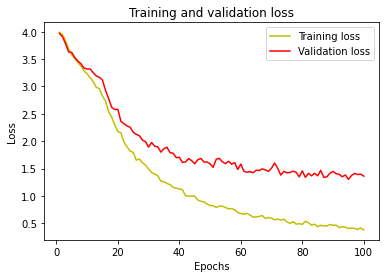

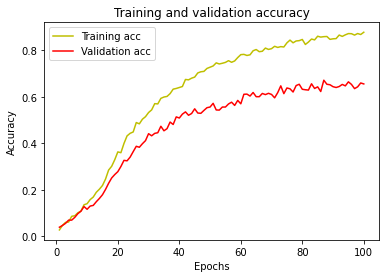

[[22  0  0 ...  2  0  0]
 [ 0 24  0 ...  0  1  1]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 1  0  0 ... 12  0  0]
 [ 0  2  0 ...  0 18  0]
 [ 0  1  1 ...  0  0 10]]
              precision    recall  f1-score   support

           0       0.65      0.63      0.64        35
           1       0.46      0.73      0.56        33
           2       0.85      0.59      0.69        29
           3       0.74      0.80      0.77        25
           4       0.63      0.67      0.65        36
           5       0.46      0.79      0.58        28
           6       0.69      0.72      0.71        25
           7       0.85      0.92      0.88        24
           8       0.84      0.57      0.68        37
           9       0.65      0.37      0.47        30
          10       0.75      0.68      0.71        56
          11       0.47      0.42      0.44        19
          12       0.67      0.64      0.65        25
          13       0.68      0.76      0.72        34
          14       0.84      0.94

In [53]:
test = "eksperyment5_4"
filters = 128
neurons = 128
kernel = 2
dropout = 0.5
window_size = 40

(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)
model = build_model(filters, kernel, neurons, dropout) 
train_model(model, 'Adam')
matrix, accuracy = manage_results(model, filters, neurons)


In [52]:
np.set_printoptions(threshold=1000)


In [54]:
accuracy

0.6551006245662734

train_model(model, 'Adam')
matrix, accuracy = manage_results(model, filters, neurons)

In [55]:
cnf_matrix = matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)


In [56]:
sumFPR = sum(FPR)/54

In [57]:
sumFPR

0.0065147120865136

In [58]:
sumFNR = sum(FNR)/54

In [59]:
sumFNR

0.35065240655758445

In [66]:
ACC.shape

(54,)

In [61]:
EER = (sumFPR + sumFNR)/2

In [62]:
EER

0.17858355932204903

In [63]:
FNR

array([0.37142857, 0.27272727, 0.4137931 , 0.2       , 0.33333333,
       0.21428571, 0.28      , 0.08333333, 0.43243243, 0.63333333,
       0.32142857, 0.57894737, 0.36      , 0.23529412, 0.05882353,
       0.66666667, 0.39285714, 0.125     , 0.21875   , 0.44      ,
       0.4       , 0.16666667, 0.60869565, 0.36363636, 0.06060606,
       0.42857143, 0.13793103, 0.20833333, 0.38888889, 0.625     ,
       0.23809524, 0.47826087, 0.08695652, 0.4516129 , 0.19230769,
       0.32258065, 0.77777778, 0.55555556, 0.27272727, 0.42105263,
       0.34782609, 0.13636364, 0.64516129, 0.48275862, 0.33333333,
       0.25      , 0.55      , 0.27777778, 0.4375    , 0.375     ,
       0.16666667, 0.33333333, 0.18181818, 0.6       ])